In [1]:
import pandas as pd
import os

from scipy import signal

import matplotlib.pyplot as plt

import numpy as np

from pydantic import BaseModel, Field
from typing import List

In [2]:
class CarpetRegion(BaseModel):
    start_hz: float = Field(..., description="Start frequency in Hz")
    end_hz: float = Field(..., description="End frequency in Hz")
class Wave(BaseModel):
    time: List[float] = Field(..., description="Time points of the wave")
    signal: List[float] = Field(..., description="Signal values")


class Model:
    def __init__(self, **params):
        # Store hyperparameters if needed
        self.params = params
    def predict(self, wave: Wave) -> List[CarpetRegion]:
        """
        Predict carpet regions from a given wave.
        This should be implemented with actual logic.
        """
        # Example placeholder
        raise NotImplementedError("Predict method not implemented.")


# def moving_average(x, w):
#     return np.convolve(x, np.ones(w), 'valid') / w

<Axes: >

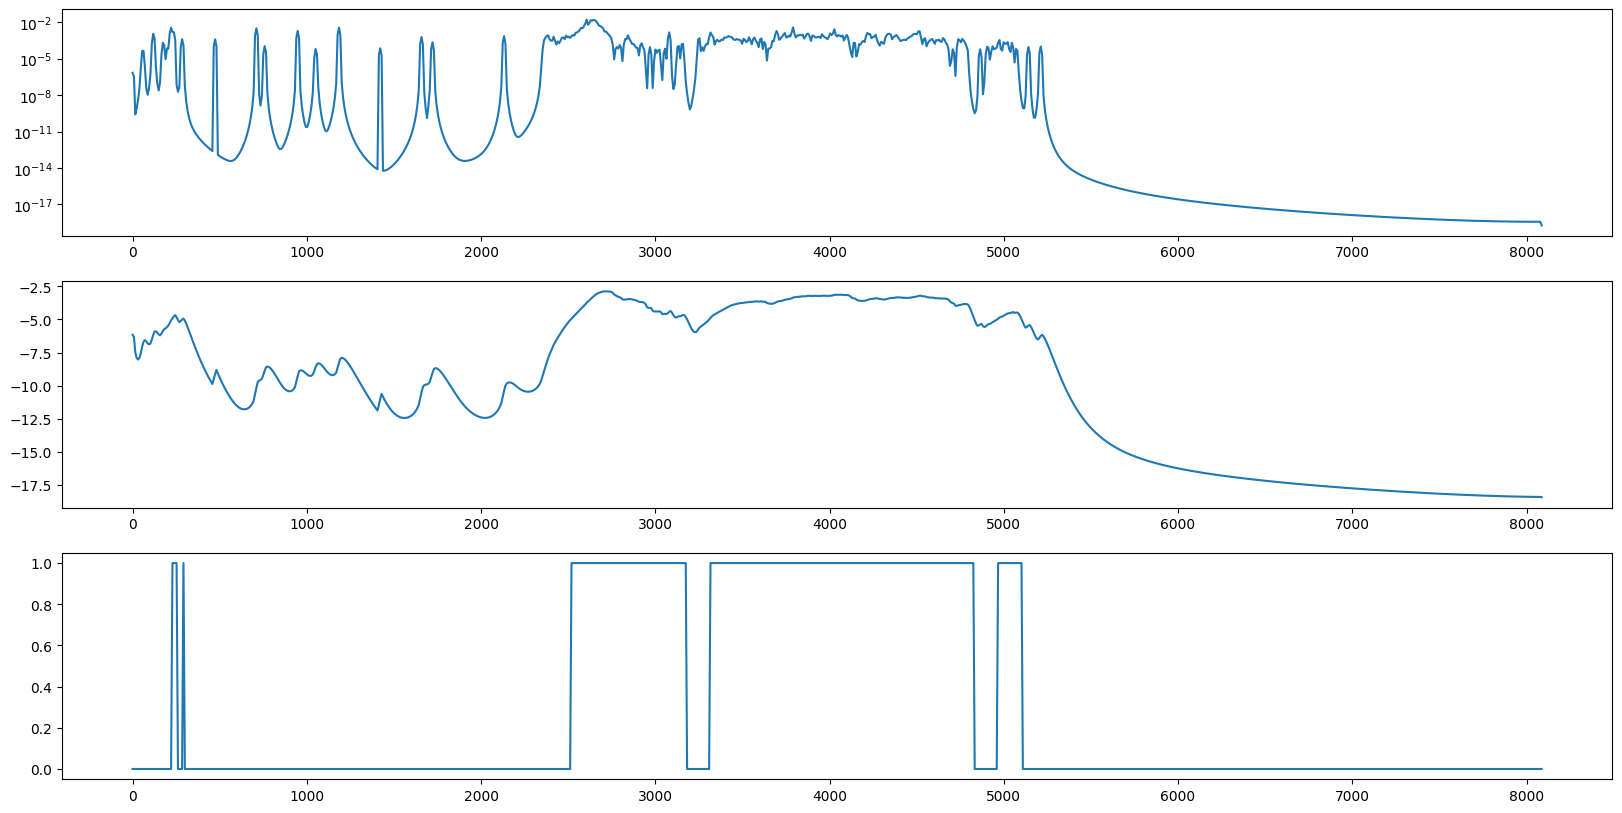

In [19]:
path = "./part_2/"
files = os.listdir(path)

data = pd.read_csv(path+files[2])

fs = data.shape[0] / data["t"].max()          # taxa de amostragem
f, Pxx = signal.welch(data["data"].to_numpy(), fs=fs, window='hann', nperseg=2048, noverlap=1024, scaling='density')


fig,axs = plt.subplots(3,1,figsize=(20,10))
w = 32
axs[0].semilogy(f,Pxx)
smoothedW = (pd.Series(Pxx,index=f).apply(np.log10).ewm(span=w).mean())
(smoothedW).plot(ax=axs[1])
((smoothedW > -5)*1).plot(ax=axs[2])

In [13]:
fs = fs
nperseg = 1024
noverlap = 256
window = 'hann'

f, t, Zxx = signal.stft(
    data["data"].to_numpy(),
    fs=fs,
    window=window,
    nperseg=nperseg,
    noverlap=noverlap,
    return_onesided=True
)

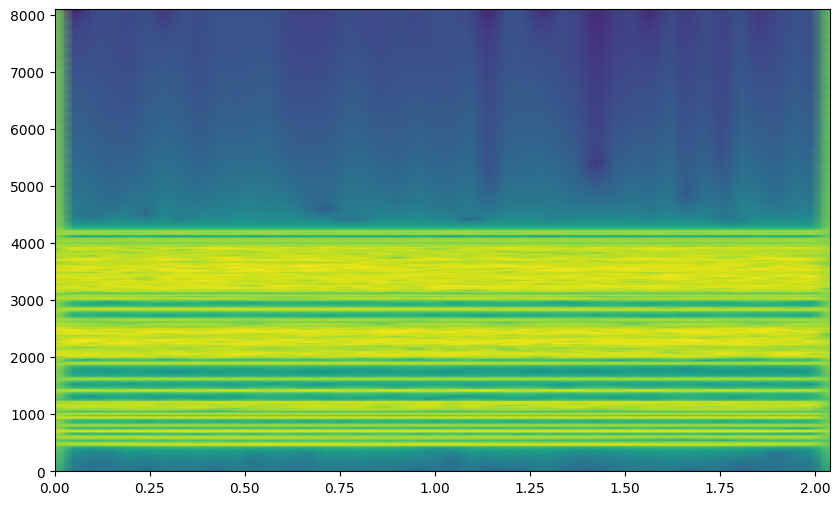

In [15]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')

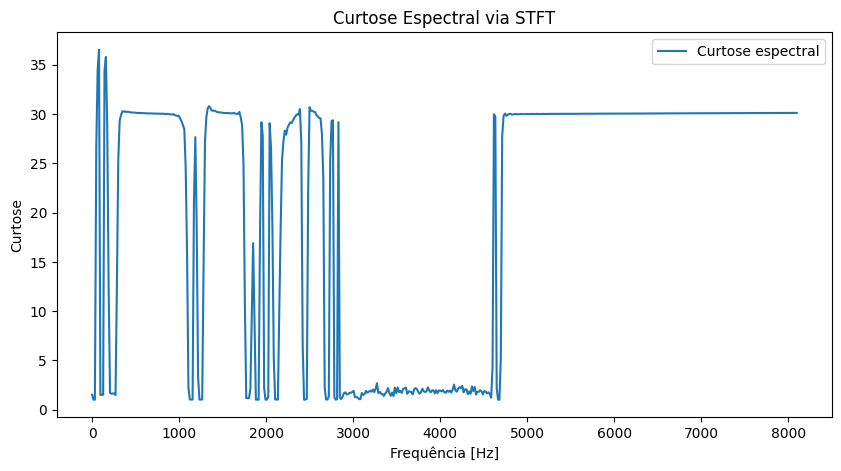

In [ ]:
P = np.abs(Zxx)**2  # (freq x tempo)

# Média no tempo
m2 = np.mean(P, axis=1)      # segundo momento
m4 = np.mean(P**2, axis=1)   # quarto momento

# Curtose espectral
K = m4 / (m2**2)

# =========================
# 3. Plotar resultado
# =========================
plt.figure(figsize=(10,5))
plt.plot(f, K, label="Curtose espectral")
plt.xlabel("Frequência [Hz]")
plt.ylabel("Curtose")
plt.title("Curtose Espectral via STFT")
#plt.grid(True)
plt.legend()
plt.show()

In [8]:
condA = np.log10(Pxx) > np.log10(Pxx.mean())

condB = f>1000




In [9]:
plt.plot(np.log10(Pxx[condA*condB]))

ValueError: operands could not be broadcast together with shapes (1025,) (513,) 

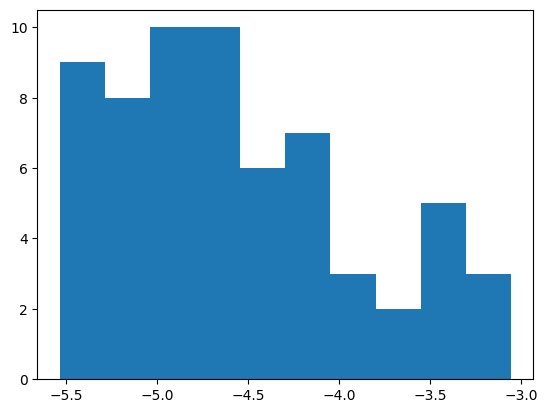

In [ ]:
count = plt.hist(np.log10(Pxx[condA*condB]), bins=10)

In [ ]:
smoothedW

0       -0.183216
1       -0.375986
2       -0.705095
3       -1.028860
4       -1.345958
          ...    
2044   -21.967253
2045   -21.967659
2046   -21.968043
2047   -21.968407
2048   -21.978156
Length: 2049, dtype: float64